# Advanced line detection

## Import packages

In [11]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Camera Calibration

### Load and display images for calibration:

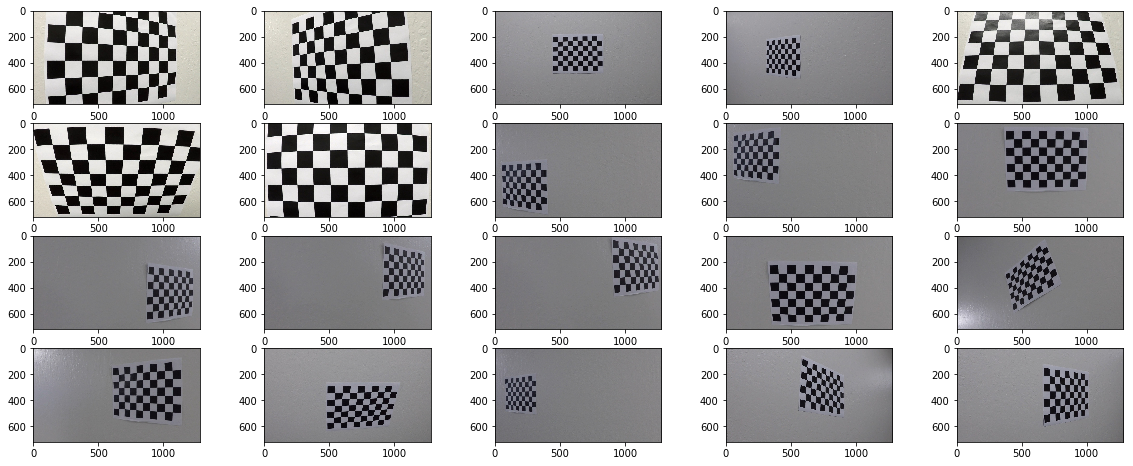

In [14]:
plt.figure(figsize=(20,10))
columns = 5
calibration_image_list = os.listdir("camera_cal/")

for i,fileName in enumerate(calibration_image_list):
    image = mpimg.imread('camera_cal/' + fileName)
    plt.subplot(len(calibration_image_list) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [16]:
### Calibrate the camera

In [43]:
import glob
# read images for calibration 
calibration_image_list = glob.glob('camera_cal/calibration*.jpg')

nx = 9 # corners in x dimension
ny = 6 # corners in y dimension




# images with corners
images_with_corners = []

# undistored images 
undistored_images = []

for i,fileName in enumerate(calibration_image_list):
    # points collections
    objpoints = []
    imgpoints = []

    # prepare object points
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    image = mpimg.imread(fileName)

    # conver to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # try to find a corners 
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # if found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # draw and display the corners
        cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        images_with_corners.append(image)
        
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        
        undistored_images.append(dst) 



print("found ", len(images_with_corners), "image(s) with corners in ", len(calibration_image_list), "images")
        

found  17 image(s) with corners in  20 images


### Show images with cornes

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


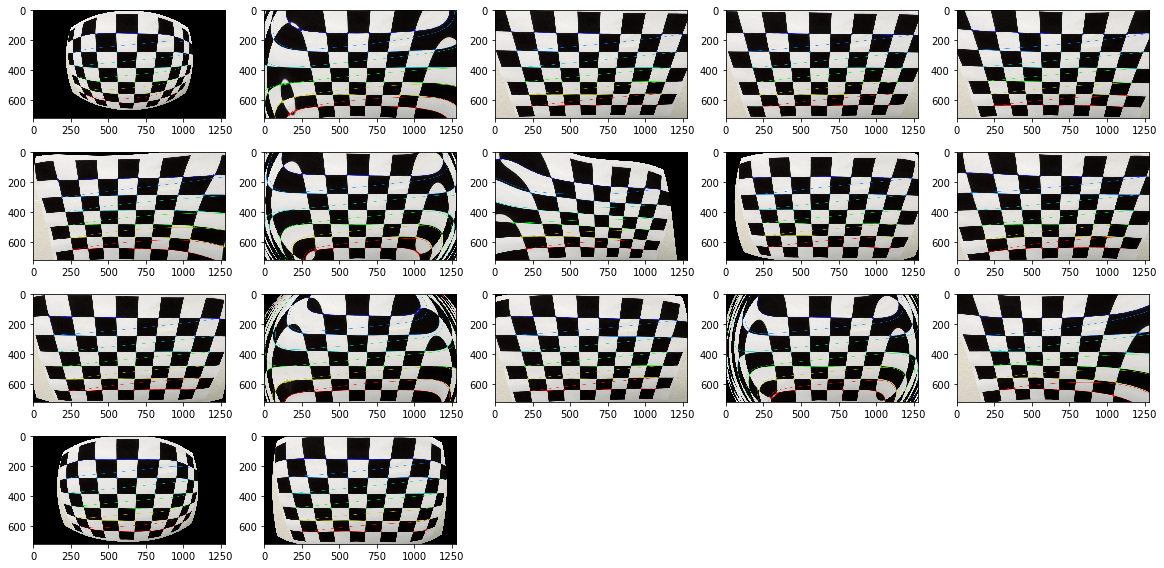

In [44]:
plt.figure(figsize=(20,10))
columns = 5

for i,image in enumerate(images_with_corners):
    plt.subplot(len(images_with_corners) / columns + 1, columns, i + 1)
    plt.imshow(image)
    

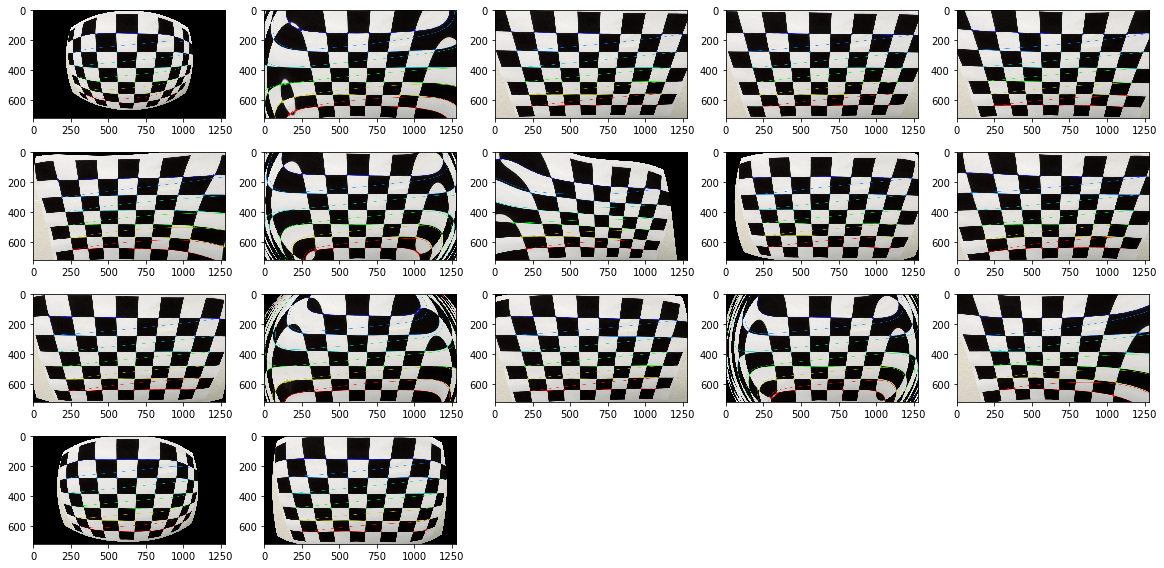

In [46]:
plt.figure(figsize=(20,10))
columns = 5

for i,image in enumerate(undistored_images):
    plt.subplot(len(undistored_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/calib3d/src/calibration.cpp:3384: error: (-215:Assertion failed) nimages > 0 in function 'calibrateCamera'
